In [2]:
# If you're in Colab or a machine with internet, uncomment to install.
%pip -q install -U torch sentence-transformers scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.8/899.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 6.4 MB/s eta 0:00:000:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 17.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os, random, math, itertools
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader

import torch
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [15]:
# === Config ===
DATASET_CSV = r"/kaggle/input/triplit-large/triplet_samples (2).csv"  # update path if needed
COL_A = "sentence2"
COL_B = "sentence1"
LABEL_COL = "label"  # 1=similar, 0=dissimilar

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 32
EPOCHS = 2
MARGIN = 0.2
MAX_TRIPLETS_PER_ANCHOR = 4
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [16]:
df = pd.read_csv(DATASET_CSV)
assert all(c in df.columns for c in [COL_A, COL_B, LABEL_COL]), f"Expected columns {[COL_A, COL_B, LABEL_COL]} not found. Found: {list(df.columns)}"
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)
print(df.head())
print("Counts:", df[LABEL_COL].value_counts().to_dict())


                                           sentence1  \
0               Their Nasdaq ticker symbol was NTIQ.   
1                    There is no chain of narration.   
2  The equivalent Japanese term for "dojang" is "...   
3           Salido lost the bout via split decision.   
4  An ABC News poll found that the majority (58%)...   

                                           sentence2  label  
0  Certain intellectual property assets are plann...      0  
1  It relates to the autocorrelations of the time...      0  
2  Unlike other paints that create special effect...      0  
3  The figure shows a set "X" of 16 points in the...      0  
4  The poll found opposition to same-sex marriage...      1  
Counts: {0: 50000, 1: 50000}


In [17]:
from collections import defaultdict

def build_triplets_from_pairs(df, col_a, col_b, label_col, max_triplets_per_anchor=None, include_reverse=True):
    """Construct (anchor, positive, negative) triplets from pairwise similarity labels."""
    da = df[col_a].astype(str).tolist()
    db = df[col_b].astype(str).tolist()
    dl = df[label_col].astype(int).tolist()

    pos = defaultdict(set)
    neg = defaultdict(set)

    for a, b, y in zip(da, db, dl):
        if y == 1:
            pos[a].add(b)
            if include_reverse:
                pos[b].add(a)
        else:
            neg[a].add(b)
            if include_reverse:
                neg[b].add(a)

    triplets = []
    for anchor, pos_set in pos.items():
        neg_set = neg.get(anchor, set())
        if not pos_set or not neg_set:
            continue

        pos_list = list(pos_set)
        neg_list = list(neg_set)
        random.shuffle(pos_list); random.shuffle(neg_list)

        if max_triplets_per_anchor:
            pos_list = pos_list[:max_triplets_per_anchor]
            neg_list = neg_list[:max_triplets_per_anchor]

        for p in pos_list:
            for n in neg_list:
                triplets.append((anchor, p, n))

    return triplets

triplets = build_triplets_from_pairs(df, COL_A, COL_B, LABEL_COL, max_triplets_per_anchor=MAX_TRIPLETS_PER_ANCHOR, include_reverse=True)
print(f"Built {len(triplets):,} triplets from {len(df):,} pairs.")
print('Example:', triplets[0] if len(triplets)>0 else None)


Built 9,558 triplets from 100,000 pairs.
Example: ('or upon order of the House;', 'operations and performance of the committees;', 'Although the Chilean model has been recommended for adoption in other Latin American countries, none has yet accepted it in its original form.')


In [18]:
train_examples = [InputExample(texts=[a, p, n]) for (a,p,n) in triplets]
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)

model = SentenceTransformer(MODEL_NAME)
train_loss = losses.TripletLoss(model=model, distance_metric=losses.SiameseDistanceMetric.COSINE_DISTANCE)

print(f"Model: {MODEL_NAME}")
print(f"Triplets: {len(train_examples):,} | Batch size: {BATCH_SIZE} | Epochs: {EPOCHS} | Margin: {MARGIN}")


Model: sentence-transformers/all-MiniLM-L6-v2
Triplets: 9,558 | Batch size: 32 | Epochs: 2 | Margin: 0.2


In [19]:
from sklearn.metrics import roc_auc_score
from sentence_transformers import util

@torch.no_grad()
def quick_eval(model, pairs_df, col_a, col_b, label_col, sample_size=2000):
    pairs = pairs_df.sample(n=min(sample_size, len(pairs_df)), random_state=SEED)
    a_emb = model.encode(pairs[col_a].astype(str).tolist(), convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
    b_emb = model.encode(pairs[col_b].astype(str).tolist(), convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
    sims = util.cos_sim(a_emb, b_emb).diagonal().cpu().numpy()
    y = pairs[label_col].to_numpy().astype(int)
    auc = roc_auc_score(y, sims)
    return auc, sims, y

print("Running quick pre-train AUC...")
pre_auc, pre_sims, pre_y = quick_eval(model, df, COL_A, COL_B, LABEL_COL, sample_size=2000)
print(f"Pre-train ROC-AUC (pairwise similarity): {pre_auc:.4f}")


Running quick pre-train AUC...
Pre-train ROC-AUC (pairwise similarity): 0.9308


In [ ]:
import os
# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"
warmup_steps = int(len(train_dataloader) * EPOCHS * 0.1)
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=10,
    warmup_steps=warmup_steps,
    output_path=OUTPUT_DIR,
    show_progress_bar=True
)
print("Training complete. Model saved to:", OUTPUT_DIR)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,3.160500
1000,3.157400
1500,3.147700
2000,3.142700
2500,3.141100


Post-train ROC-AUC (pairwise similarity): 0.9184


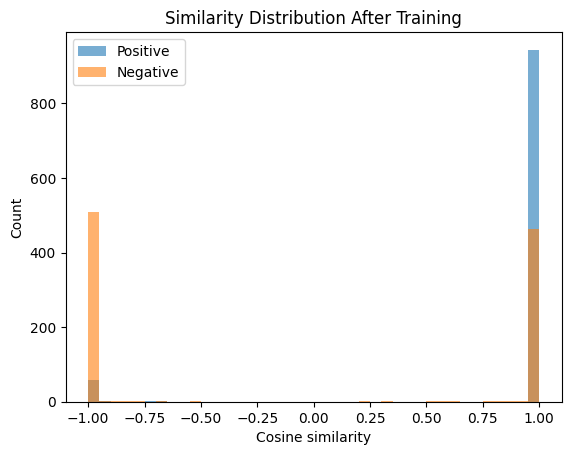

In [30]:
fine_tuned = SentenceTransformer(OUTPUT_DIR)
post_auc, post_sims, post_y = quick_eval(fine_tuned, df, COL_A, COL_B, LABEL_COL, sample_size=2000)
print(f"Post-train ROC-AUC (pairwise similarity): {post_auc:.4f}")

plt.figure()
plt.hist(post_sims[post_y==1], bins=40, alpha=0.6, label="Positive")
plt.hist(post_sims[post_y==0], bins=40, alpha=0.6, label="Negative")
plt.title("Similarity Distribution After Training")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.legend()
plt.show()


In [22]:
examples = [
    (df.iloc[0][COL_A], df.iloc[0][COL_B]),
    (df.iloc[1][COL_A], df.iloc[1][COL_B]),
]
emb_a = fine_tuned.encode([ex[0] for ex in examples], convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
emb_b = fine_tuned.encode([ex[1] for ex in examples], convert_to_tensor=True, show_progress_bar=False, normalize_embeddings=True)
sims = util.cos_sim(emb_a, emb_b).diagonal().cpu().numpy()
for (ta, tb), s in zip(examples, sims):
    print(f"Sim = {s:.3f}\nA: {str(ta)[:120]}\nB: {str(tb)[:120]}\n---")


Sim = 0.574
A: Certain intellectual property assets are planned to be sold to CPTN Holdings, a consortium of companies led by Microsoft
B: Their Nasdaq ticker symbol was NTIQ.
---
Sim = 0.448
A: It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of 
B: There is no chain of narration.
---


In [ ]:
all_texts = pd.unique(pd.concat([df[COL_A].astype(str), df[COL_B].astype(str)], ignore_index=True)).tolist()
print(f"Encoding {len(all_texts):,} unique texts...")
emb = fine_tuned.encode(all_texts, convert_to_tensor=False, show_progress_bar=True, normalize_embeddings=True)
emb = np.asarray(emb, dtype=np.float32)
np.save(os.path.join(OUTPUT_DIR, "corpus_embeddings.npy"), emb)
pd.Series(all_texts).to_csv(os.path.join(OUTPUT_DIR, "corpus_texts.csv"), index=False)
print("Saved corpus embeddings and texts to:", OUTPUT_DIR)
